# Titanic - Learning From Disaster exploration of optimisation techniques

## Introduction
This notebook present my research on diverse optimisation techniques on the Titanic dataset. The idea is to train a model able to perform decently in the Kaggle competition, while applying diverse optimisation techniques such as outlier detection and removal, as well as upsampling and downsampling and observe the impact on the model's performance. First, the dataset will be explored to derive useful transformations that will allow to build an efficient baseline model. Then, further experiments will be made using the same model, but using different different techniques such as outlier removal, upsampling and / or downsampling.
Submissions will be used to confirm the improvements that were brought on the model.








In [ ]:
# Imports
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt

from sklearn.preprocessing import OrdinalEncoder, StandardScaler, OneHotEncoder, TargetEncoder, KBinsDiscretizer
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import GradientBoostingClassifier, IsolationForest
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import make_scorer, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE

In [ ]:
print(sklearn.__version__)

1.6.1


## Data Exploration
### Data Loading


In [ ]:
df_train = pd.read_csv('./data/titanic/train.csv')
df_test = pd.read_csv('./data/titanic/test.csv')

### Data Quality Report (DQR)
#### Continous features

In [ ]:
df_continuous = df_train.select_dtypes(include=["int64", "float64"])

def continuous_dqr(df):
    dqr_continuous = pd.DataFrame({
        'Features': df.columns,
        'Count': df.count(),
        'Missing Values': df.isnull().sum(),
        'Missing Values %': (df.isnull().sum() / len(df)) * 100,
        'Cardinality': df.nunique(),
        'Min': df.min(),
        '1st Quartile': df.quantile(0.25),
        'Mean': df.mean(),
        'Median': df.median(),
        '3rd Quartile': df.quantile(0.75),
        'Max': df.max(),
        'Standard Deviation': df.std(),
    })

    dqr_continuous.index = range(1, len(dqr_continuous) + 1)
    return dqr_continuous

continuous_dqr(df_continuous)

,Features,Count,Missing Values,Missing Values %,Cardinality,Min,1st Quartile,Mean,Median,3rd Quartile,Max,Standard Deviation
1,PassengerId,891,0,0.00000,891,1.00,223.5000,446.000000,446.0000,668.5,891.0000,257.353842
2,Survived,891,0,0.00000,2,0.00,0.0000,0.383838,0.0000,1.0,1.0000,0.486592
3,Pclass,891,0,0.00000,3,1.00,2.0000,2.308642,3.0000,3.0,3.0000,0.836071
4,Age,714,177,19.86532,88,0.42,20.1250,29.699118,28.0000,38.0,80.0000,14.526497
5,SibSp,891,0,0.00000,7,0.00,0.0000,0.523008,0.0000,1.0,8.0000,1.102743
6,Parch,891,0,0.00000,7,0.00,0.0000,0.381594,0.0000,0.0,6.0000,0.806057
7,Fare,891,0,0.00000,248,0.00,7.9104,32.204208,14.4542,31.0,512.3292,49.693429


Looking at the Continuous Features DQR, it is observable that `PassengerId` is an identifier for the passengers instances. Which makes this feature irrelevant for the prediction task. Regarding `Survived`, it is observable that most passengers did not survived the crash (`38.4%` of survivors). Most of the passengers travelled in 2nd or 3rd class. The `Age` feature is missing around `20%` and an assessment will have to be conducted to understand if the missing values can be imputed. Most passengers were travelling alone, and we note the feature `SibSp` representing the number of siblings / spouses and `Parch`, representing the number of parents / children have different max values. Which is an indication that some passengers were travelling with their nannies and parents were not onboard, which could be an impactful information related to chances of survival. Finally, `Fare` has a very high standard deviation, no missing values and represents the amount paid for the ticket. This could be linked to the person's status or whether one person paid several tickets for a family and could be further investigated.

#### Categorical features

In [ ]:
def categorical_dqr(df):
    dqr_categorical = pd.DataFrame({
        'Features': df.columns,
        'Missing Values': df.isnull().sum(),
        'Missing Values %': (df.isnull().sum() / len(df)) * 100,
        'Cardinality': df.nunique(),
        'Mode': df.mode().iloc[0],
        'Mode Frequency': df.apply(lambda x: x.value_counts().values[0]),
        "Mode frequency %": df.apply(lambda x: (x.value_counts().values[0] / len(df)) * 100),
        "2nd mode": df.apply(lambda x: 'NA' if len(x.value_counts()) == 1 else x.value_counts().index[1]),
        "2nd mode frequency": df.apply(lambda x: 0 if len(x.value_counts()) == 1 else x.value_counts().values[1]),
        "2nd mode frequency %": df.apply(lambda x: 0 if len(x.value_counts()) == 1 else (x.value_counts().values[1]) / len(df)) * 100})

    dqr_categorical.index = range(1, len(dqr_categorical) + 1)
    return dqr_categorical

df_categorical = df_train.select_dtypes(include=["object"])
categorical_dqr(df_categorical)

,Features,Missing Values,Missing Values %,Cardinality,Mode,Mode Frequency,Mode frequency %,2nd mode,2nd mode frequency,2nd mode frequency %
1,Name,0,0.000000,891,"Abbing, Mr. Anthony",1,0.112233,"Boulos, Mr. Hanna",1,0.112233
2,Sex,0,0.000000,2,male,577,64.758698,female,314,35.241302
3,Ticket,0,0.000000,681,1601,7,0.785634,CA. 2343,7,0.785634
4,Cabin,687,77.104377,147,B96 B98,4,0.448934,G6,4,0.448934
5,Embarked,2,0.224467,3,S,644,72.278339,C,168,18.855219


Looking at the continous DQR, it is observable that Name is unique but contains information that could be extracted such as `Title`. Most passengers are male (around `65%`) and female represent around `35%` of the passenger count. The `Ticket` feature represents the ticket number of the passenger, as of now it does not seem to carry a lot of information, but should not necessarilly discarded. The `Cabin` feature is missing `77%` of its data and it may be difficult to impute these. However, it would be interesting to understand if having the cabin defined is impactful on the chances of survival since it may indicate that the passenger was able to tell which cabin was he assigned after the crash. Finally, `Embarked` represents the port where passengers boarded. Since it is missing very few values, it will be possible to impute the mode as a first option if necessary.

### Correlations

In [ ]:
correlation = df_train.select_dtypes(exclude='object').corr()
correlation.style.background_gradient(cmap='BrBG')

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
PassengerId,1.000000,-0.005007,-0.035144,0.036847,-0.057527,-0.001652,0.012658
Survived,-0.005007,1.000000,-0.338481,-0.077221,-0.035322,0.081629,0.257307
Pclass,-0.035144,-0.338481,1.000000,-0.369226,0.083081,0.018443,-0.549500
Age,0.036847,-0.077221,-0.369226,1.000000,-0.308247,-0.189119,0.096067
SibSp,-0.057527,-0.035322,0.083081,-0.308247,1.000000,0.414838,0.159651
Parch,-0.001652,0.081629,0.018443,-0.189119,0.414838,1.000000,0.216225
Fare,0.012658,0.257307,-0.549500,0.096067,0.159651,0.216225,1.000000


#### Biggest correlations between features

In [ ]:
upper_tri = correlation.where(np.triu(np.ones(correlation.shape), k=1).astype(bool))
correlations = upper_tri.unstack().sort_values(ascending=False)
top_correlations = correlations.head(5)
top_correlations

Parch  SibSp       0.414838
Fare   Survived    0.257307
       Parch       0.216225
       SibSp       0.159651
       Age         0.096067
dtype: float64

Looking at the top correlations, an observation can be made that `Parch` and `SibSp` are moderately correlated with each others, which can be explained by the fact they represent family information (parents/siblings).
`Fare` is weakly correlated with `Survived` and `Parch` but smaller correlations exist with `SibSp` and `Age`. This is a useful source of information that indicated Fare could be a determining factor on the chance of survival.

#### Biggest correlations with Survived feature

In [ ]:
# TODO Add whether or not these are positive or negative correlations
feature_correlations = correlation['Survived'].drop('Survived')
strongest_correlations = feature_correlations.abs().sort_values(ascending=False)
strongest_correlations

,Survived
Pclass,0.338481
Fare,0.257307
Parch,0.081629
Age,0.077221
SibSp,0.035322
PassengerId,0.005007


When looking at the strongest correlations between features and the target variable `Survived` it is observable that the biggest determining factors are the `Pclass` of the passenger, the `Fare` the passenger paid. Weaker correlations can be observed with `Parch`, `Age` and `SibSp` which indicates these values also have an impact on the survival rate.

### Visualisations

<ipython-input-486-a965cdd15837>:5: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  df_reshaped = age_survival.pivot_table(index=['binned_age'], columns=['Survived'], aggfunc=len)


<Axes: title={'center': 'Age group frequency by Survived'}, xlabel='Age binned', ylabel='Frequency'>

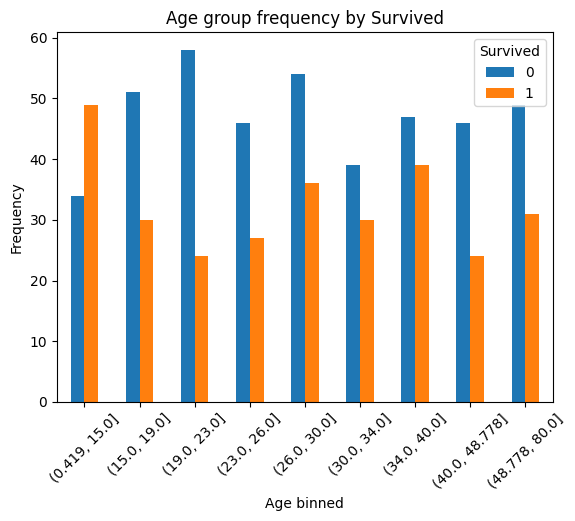

In [ ]:
age_survival = df_train[['Age', 'Survived']].copy()
age_survival['binned_age'] = pd.qcut(age_survival.Age, 9)

age_survival.drop('Age',axis=1,inplace=True)
df_reshaped = age_survival.pivot_table(index=['binned_age'], columns=['Survived'], aggfunc=len)

df_reshaped.plot(kind='bar', stacked=False, ylabel='Frequency', xlabel='Age binned',
                 title='Age group frequency by Survived', rot=45)

<ipython-input-487-10626f229c73>:5: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  df_reshaped = age_survival.pivot_table(index=['binned_fare'], columns=['Survived'], aggfunc=len)


<Axes: title={'center': 'Fare frequency by Survived'}, xlabel='Fare binned', ylabel='Frequency'>

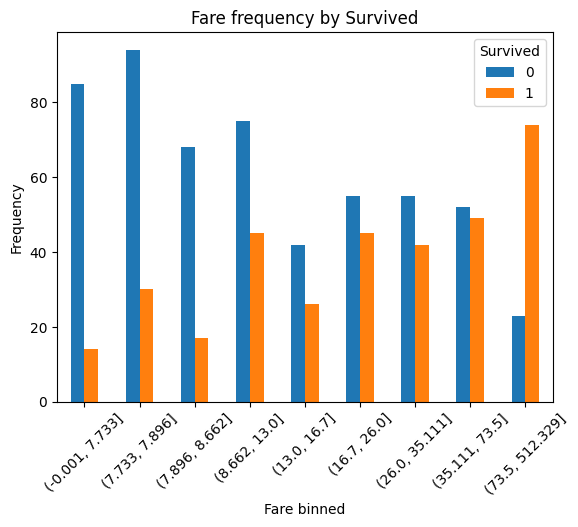

In [ ]:
age_survival = df_train[['Fare', 'Survived']].copy()
age_survival['binned_fare'] = pd.qcut(age_survival.Fare, 9)

age_survival.drop('Fare',axis=1,inplace=True)
df_reshaped = age_survival.pivot_table(index=['binned_fare'], columns=['Survived'], aggfunc=len)

df_reshaped.plot(kind='bar', stacked=False, ylabel='Frequency', xlabel='Fare binned',
                 title='Fare frequency by Survived', rot=45)

<Axes: title={'center': 'Pclass frequency by Survived'}, xlabel='Pclass', ylabel='Frequency'>

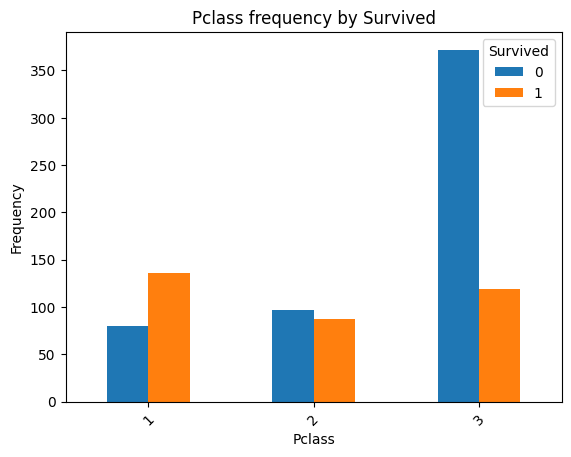

In [ ]:
age_survival = df_train[['Pclass', 'Survived']].copy()

df_reshaped = age_survival.pivot_table(index=['Pclass'], columns=['Survived'], aggfunc=len)

df_reshaped.plot(kind='bar', stacked=False, ylabel='Frequency', xlabel='Pclass',
                 title='Pclass frequency by Survived', rot=45)

<Axes: title={'center': 'Has Cabin frequency by Survived'}, xlabel='Has_Cabin', ylabel='Frequency'>

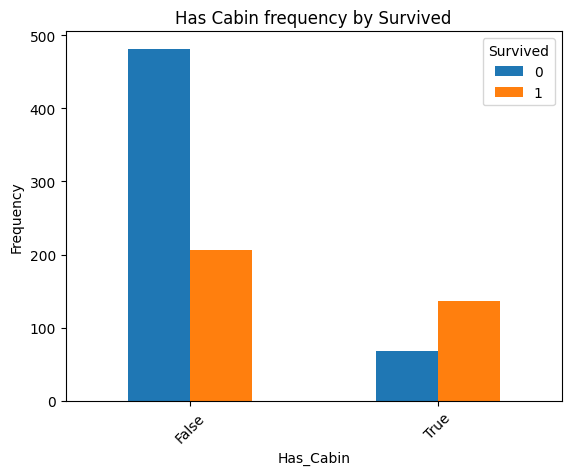

In [ ]:
df_imputed_missing_cabin = df_train.copy()
df_imputed_missing_cabin['Has_Cabin'] = df_imputed_missing_cabin['Cabin'].apply(lambda x: False if x is np.nan else True)

age_survival = df_imputed_missing_cabin[['Has_Cabin', 'Survived']].copy()

df_reshaped = age_survival.pivot_table(index=['Has_Cabin'], columns=['Survived'], aggfunc=len)

df_reshaped.plot(kind='bar', stacked=False, ylabel='Frequency', xlabel='Has_Cabin',
                 title='Has Cabin frequency by Survived', rot=45)

<ipython-input-490-36fa88c7aec5>:5: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  df_reshaped = age_survival.pivot_table(index=['Has_Cabin'], columns=['binned_age'], aggfunc=len)


<Axes: title={'center': 'Has Cabin frequency by Age'}, xlabel='Has_Cabin', ylabel='Frequency'>

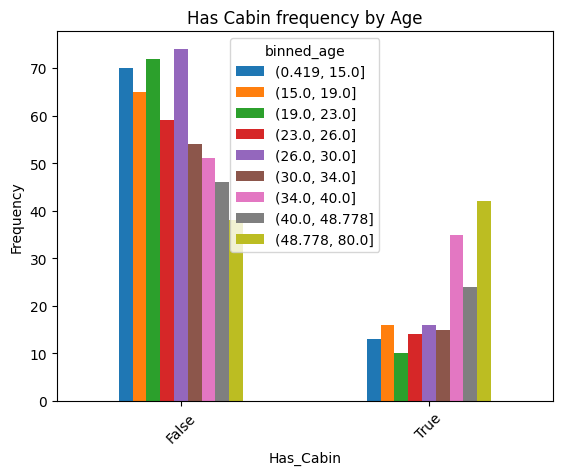

In [ ]:
age_survival = df_imputed_missing_cabin[['Has_Cabin', 'Age']].copy()
age_survival['binned_age'] = pd.qcut(age_survival.Age, 9)

age_survival.drop('Age',axis=1,inplace=True)
df_reshaped = age_survival.pivot_table(index=['Has_Cabin'], columns=['binned_age'], aggfunc=len)

df_reshaped.plot(kind='bar', stacked=False, ylabel='Frequency', xlabel='Has_Cabin',
                 title='Has Cabin frequency by Age', rot=45)

## Feature engineering
In this iteration, relatively simple feature engineering will be made. This, to produce a model quickly and observe what results are achievable with simple operations. First, the `Age` will be imputed using the passenger's `Title` from the name. The imputation will be made by looking at the `median` age of the passenger looking at their `Pclass` and `Title`, this will ensure a more representative approach than using `Sex` or `Pclass` only. This method was sourced from the following Notebook: https://www.kaggle.com/code/allohvk/titanic-missing-age-imputation-tutorial-advanced which contains more advanced explanation about the imputation's methodology.
Once `Age` is imputed, binning will be applied on the feature, same for `Fare` in order to ease the extraction of useful information while reducing training time. Some features will be removed such as `PassengerId`, `Name`, `Cabin` as they are either missing too many information or do not carry meaningful information on their own.
Finally, `OneHotEncoding` will be applied to categorical data and `StandardScaler` will be applied to continuous information. Note that Pclass will use `OrdinalEncoder` for now but could be moved to OneHotEnocder in future iterations.

### Age imputation

In [ ]:
def impute_age(df: pd.DataFrame):
    df_copy=df.copy()
    df_copy['Title'] = df_copy['Name'].str.extract('([A-Za-z]+)\.', expand=True)
    df_copy['Title_Initial'] = df_copy['Title']

    mapping = {'Mlle': 'Miss', 'Major': 'Mr', 'Col': 'Mr', 'Sir': 'Mr',
               'Don': 'Mr', 'Mme': 'Mrs', 'Jonkheer': 'Mr', 'Lady': 'Mrs',
               'Capt': 'Mr', 'Countess': 'Mrs', 'Ms': 'Miss', 'Dona': 'Mrs'}

    df_copy.replace({'Title': mapping}, inplace=True)

    median_age_by_title = df_copy.groupby(['Title', 'Pclass'], as_index=False)['Age'].median()

    def extract_age(row):
        if np.isnan(row.Age):
            valu=median_age_by_title[(median_age_by_title['Title'] == row.Title) & (median_age_by_title['Pclass'] == row.Pclass)]['Age']
            if len(valu) > 0:
                return valu.values[0]
            else:
                return dict(df_copy.groupby('Title')['Age'].median())[row.Title]
        return row.Age

    df_copy['Age'] = df_copy[['Age', 'Title', 'Pclass']].apply(lambda x: extract_age(x), axis = 1)
    return df_copy

### Binnings

In [ ]:
def bin_age(df: pd.DataFrame):
    df_copy=df.copy()
    df_copy['AgeBin'] = pd.qcut(df_copy['Age'], 5)
    return df_copy

def bin_fare(df: pd.DataFrame):
    df_copy=df.copy()
    df_copy['FareBin'] = pd.qcut(df_copy['Fare'], 4)
    return df_copy

### Feature selection

In [ ]:
def drop_unwanted_features(df: pd.DataFrame, target, exclude=None) -> tuple[pd.DataFrame, pd.Series]:
    if exclude is None:
        exclude = []
    remove_list=['PassengerId', 'Name', 'Cabin', 'Ticket', 'Title_Initial', 'Age', 'Fare']
    final_list=[x for x in remove_list if x not in exclude]
    copy=df.copy()
    result_X=copy.drop(final_list, axis=1)
    result_y=result_X.pop(target) if target in result_X else None
    return result_X, result_y

def get_dataset_with_new_features(df: pd.DataFrame):
    copied_df=df.copy()
    copied_df=impute_age(copied_df)
    copied_df=bin_age(copied_df)
    copied_df=bin_fare(copied_df)
    return copied_df

def transform_and_select_features(df: pd.DataFrame, target='Survived', exclude=None) -> tuple[pd.DataFrame, pd.Series]:
    df_copy=df.copy()
    df_copy=get_dataset_with_new_features(df_copy)
    return drop_unwanted_features(df_copy, target, exclude)

## Model Implementation

### Pipeline Definition

In [ ]:
dt_continuous_selector=make_column_selector(dtype_include=['int64', 'float64'], pattern=r'^(?!Pclass$)')
continuous_transformer=make_pipeline(
    StandardScaler()
)

dt_categorical_selector=make_column_selector(dtype_include='object')
categorical_transformer=make_pipeline(
    OneHotEncoder(handle_unknown='ignore', sparse_output=False)
)

dt_preprocessor=make_column_transformer(
    (categorical_transformer, dt_categorical_selector),
    (continuous_transformer, dt_continuous_selector),
    (categorical_transformer, ['AgeBin', 'FareBin']),
    (make_pipeline(OrdinalEncoder(dtype='int64')), ['Pclass'])
)

def build_pipeline(classifier):
    return make_pipeline(dt_preprocessor, classifier)

### Baseline Model

In [ ]:
baseline_model = build_pipeline(GradientBoostingClassifier(random_state=42, learning_rate=0.001, n_estimators=500, max_features=0.6))
baseline_model

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7a42019303d0>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._colu...
                                                 ('pipeline-3',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['AgeBin', 'FareBin']),
                                                 ('pipeline-4',
                                                  Pipeline(steps=[('ordinalencoder',
                                                                   OrdinalEncoder(dtype='int64'))]),
                                                  ['Pclass'])])),
                ('gradientboostingclassifier',
                 GradientBoostingClassifier(learning_rate=0.001,
                                            max_features=0.6, n_estimators=500,
                                            random_state=42))])

## Baseline Model Evaluation

In [ ]:
X, y = transform_and_select_features(df_train)
k = 5

skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
scores = cross_val_score(baseline_model, X, y, cv=skf, scoring='accuracy')
print(f"Mean Cross-Validation Accuracy [{scores.mean()}]")


baseline_model.fit(X, y)

Mean Cross-Validation Accuracy [0.80023225158496]


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7a42019303d0>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._colu...
                                                 ('pipeline-3',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['AgeBin', 'FareBin']),
                                                 ('pipeline-4',
                                                  Pipeline(steps=[('ordinalencoder',
                                                                   OrdinalEncoder(dtype='int64'))]),
                                                  ['Pclass'])])),
                ('gradientboostingclassifier',
                 GradientBoostingClassifier(learning_rate=0.001,
                                            max_features=0.6, n_estimators=500,
                                            random_state=42))])

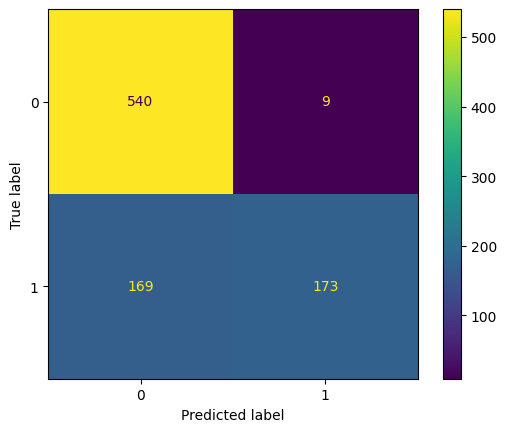

In [ ]:
ConfusionMatrixDisplay(confusion_matrix(y, baseline_model.predict(X)), display_labels=baseline_model.classes_).plot()

The baseline model achieves a precision score of `80%`, this is far from the best model's capabilities but will be enough for this iteration aiming at understanding the impact of outlier removal or SMOTE upsampling techniques.
By looking at the confusion matrix, it is possible to observe the model is better at predicting the majority class:`Not Survived`, than the minority class: `Survived`. This could be a first indication that SMOTE could be an effective way to increase accuracy since it should help the model having more samples of the minority to train on.

## Baseline model submission

In [ ]:
X_competition, df_id = transform_and_select_features(df_test, target='PassengerId', exclude=['PassengerId'])
# TODO KBins probably does not work well here
y_pred_competition=baseline_model.predict(X_competition)
final_df=pd.DataFrame(data=df_id)
final_df.insert(1, "Survived", y_pred_competition, True)
final_df.to_csv('./submission.csv', index=False)

At training time, the score achieved is `80.02%`, after submission a score of `78.47%` is achieved, which shows the model is capable to perform with a similar accuracy when submitting. We can also conclude it is not overfitting as accuracy score, although lower, is close.

## Optimisations

### Outlier removal
In this experiment, outliers are identified and removed from the dataset to observe if the model performs better with no outliers. The outliers will be detected using IsolationForest with contamination set at `1%`, meaning it is expected that 1% can be considered outliers.

In [ ]:
isolation_forest_pipeline = build_pipeline(IsolationForest(random_state=42, contamination=0.05))

isolation_forest_pipeline.fit(X, y)
y_pred_isolation_forest = isolation_forest_pipeline.predict(X)

In [ ]:
X_with_anomalies = X.copy()
X_with_anomalies['anomaly'] = y_pred_isolation_forest
X_with_anomalies['Survived'] = y

In [ ]:
X_anomaly_filtered = X_with_anomalies[X_with_anomalies['anomaly'] > 0].drop('anomaly', axis=1)
y_anomaly_filtered = X_anomaly_filtered.pop('Survived')

In [ ]:
anomaly_filtered_pipeline = build_pipeline(GradientBoostingClassifier(random_state=42, learning_rate=0.001, n_estimators=500, max_features=0.6))
anomaly_filtered_pipeline.fit(X_anomaly_filtered, y_anomaly_filtered)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7a42019303d0>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._colu...
                                                 ('pipeline-3',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['AgeBin', 'FareBin']),
                                                 ('pipeline-4',
                                                  Pipeline(steps=[('ordinalencoder',
                                                                   OrdinalEncoder(dtype='int64'))]),
                                                  ['Pclass'])])),
                ('gradientboostingclassifier',
                 GradientBoostingClassifier(learning_rate=0.001,
                                            max_features=0.6, n_estimators=500,
                                            random_state=42))])

#### Outlier removed model evaluation

In [ ]:
k = 5

skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
scores = cross_val_score(anomaly_filtered_pipeline, X_anomaly_filtered, y_anomaly_filtered, cv=skf, scoring='accuracy')
print(f"Mean Cross-Validation Accuracy [{scores.mean()}]")

Mean Cross-Validation Accuracy [0.8096762965541245]


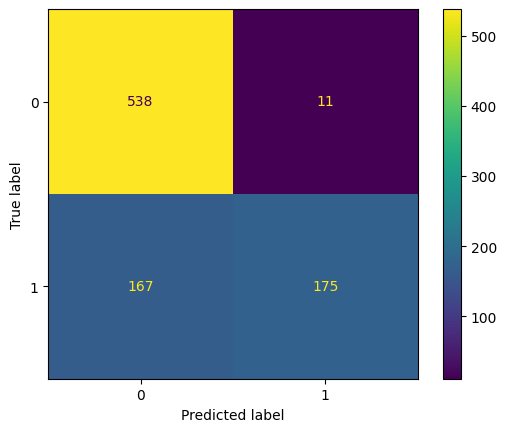

In [ ]:
ConfusionMatrixDisplay(confusion_matrix(y, anomaly_filtered_pipeline.predict(X)), display_labels=anomaly_filtered_pipeline.classes_).plot()

After outlier removal, it is observed that the model achieves a slightly higher accuracy with `80.97%` compared to `80%` in the baseline model. Looking at the confusion matrix, a slight degradation is observed on the majority class, with a slight improvement in accuracy on the minority class compared to baseline.

#### Outlier removal submission

In [ ]:
y_pred_competition=anomaly_filtered_pipeline.predict(X_competition)
final_df=pd.DataFrame(data=df_id)
final_df.insert(1, "Survived", y_pred_competition, True)
final_df.to_csv('./submission_outlier_removal.csv', index=False)

As of now, the submission score remains the same than the baseline with a `78.47%` achieved accuracy. Further analysis of the removed instances by the `IsolationForest` should be made to understand if the removed observations are relevant or not.

### SMOTE
In this experiment, SMOTE is used to generate samples from the minority class. Classic approaches of oversampling imply duplicating existing instances of the minority classes at random, leading to overfitting. While SMOTE allows to generate new, synthetic samples using neighbouring points. This should allow in principle to reduce the risk of overfitting while allowing the model to train on more samples from the minority class and improving accuracy when predicting these.

In [ ]:
sm = SMOTE(random_state=42, sampling_strategy='minority')

X_transformed = dt_preprocessor.fit_transform(X_anomaly_filtered)

print(f"Before SMOTE [{X_transformed.shape}]")

X_resampled, y_resampled = sm.fit_resample(X_transformed, y_anomaly_filtered)
number_of_generated_samples = X_resampled.shape[0] - X_transformed.shape[0]
print(f"After SMOTE [{X_resampled.shape}], a total of [{number_of_generated_samples}] were generated.")

Before SMOTE [(846, 24)]
After SMOTE [(1054, 24)], a total of [208] were generated.


##### Analysis of generated samples
In this section, an analysis of the samples generated by SMOTE is made. First, the transformations made using the pre-processor or reverted to come back to human readable features. Then, the `Survived=1` observations are isolated and compared with the generated samples from SMOTE. The aim is to understand to what extent the generated samples are similar to their counterpart. Which, will help understanding their relevance and allow to fine-tune SMOTE parameters in future iterations.

In [ ]:
resampled_df = pd.DataFrame(X_resampled, columns=dt_preprocessor.get_feature_names_out())
categorical_features = dt_preprocessor.transformers_[0][2]
continuous_features = dt_preprocessor.transformers_[1][2]
binned_features = dt_preprocessor.transformers_[2][2]
pclass_features = dt_preprocessor.transformers_[3][2]

categorical_transformer = dt_preprocessor.named_transformers_['pipeline-1']
categorical_feature_names = categorical_transformer.get_feature_names_out(categorical_features)

resampled_df = resampled_df.rename(columns={
    col: col.replace('pipeline-1__', '') for col in resampled_df.columns if 'pipeline-1__' in col
})

categorical_data_transformed = categorical_transformer.inverse_transform(resampled_df[categorical_feature_names])
categorical_df = pd.DataFrame(categorical_data_transformed, columns=categorical_features)

continuous_transformer = dt_preprocessor.named_transformers_['pipeline-2']
continuous_feature_names = continuous_transformer.get_feature_names_out(continuous_features)

resampled_df = resampled_df.rename(columns={
    col: col.replace('pipeline-2__', '') for col in resampled_df.columns if 'pipeline-2__' in col
})

continuous_data_transformed = continuous_transformer.inverse_transform(resampled_df[continuous_feature_names])
continuous_df = pd.DataFrame(continuous_data_transformed, columns=continuous_features)

binned_features = ['AgeBin', 'FareBin']
bins_transformer = dt_preprocessor.named_transformers_['pipeline-3']
binned_feature_names = bins_transformer.get_feature_names_out(binned_features)

resampled_df = resampled_df.rename(columns={
    col: col.replace('pipeline-3__', '') for col in resampled_df.columns if 'pipeline-3__' in col
})

binned_data_transformed = bins_transformer.inverse_transform(resampled_df[binned_feature_names])
binned_df = pd.DataFrame(binned_data_transformed, columns=binned_features)

pclass_transformer = dt_preprocessor.named_transformers_['pipeline-4']
pclass_feature_names = pclass_transformer.get_feature_names_out(['Pclass'])

resampled_df = resampled_df.rename(columns={
    col: col.replace('pipeline-4__', '') for col in resampled_df.columns if 'pipeline-4__' in col
})

pclass_data_transformed = pclass_transformer.inverse_transform(resampled_df[pclass_feature_names])
pclass_df = pd.DataFrame(pclass_data_transformed, columns=['Pclass'])


reversed_df = pd.concat([categorical_df, continuous_df, binned_df, pclass_df, y_resampled], axis=1)

<ipython-input-520-acacddca7366>:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  ax.bar(x_pos + bar_width / 2, survivors_df['Survived'].groupby(survivors_df[feature]).sum(),
<ipython-input-520-acacddca7366>:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  ax.bar(x_pos + bar_width / 2, survivors_df['Survived'].groupby(survivors_df[feature]).sum(),


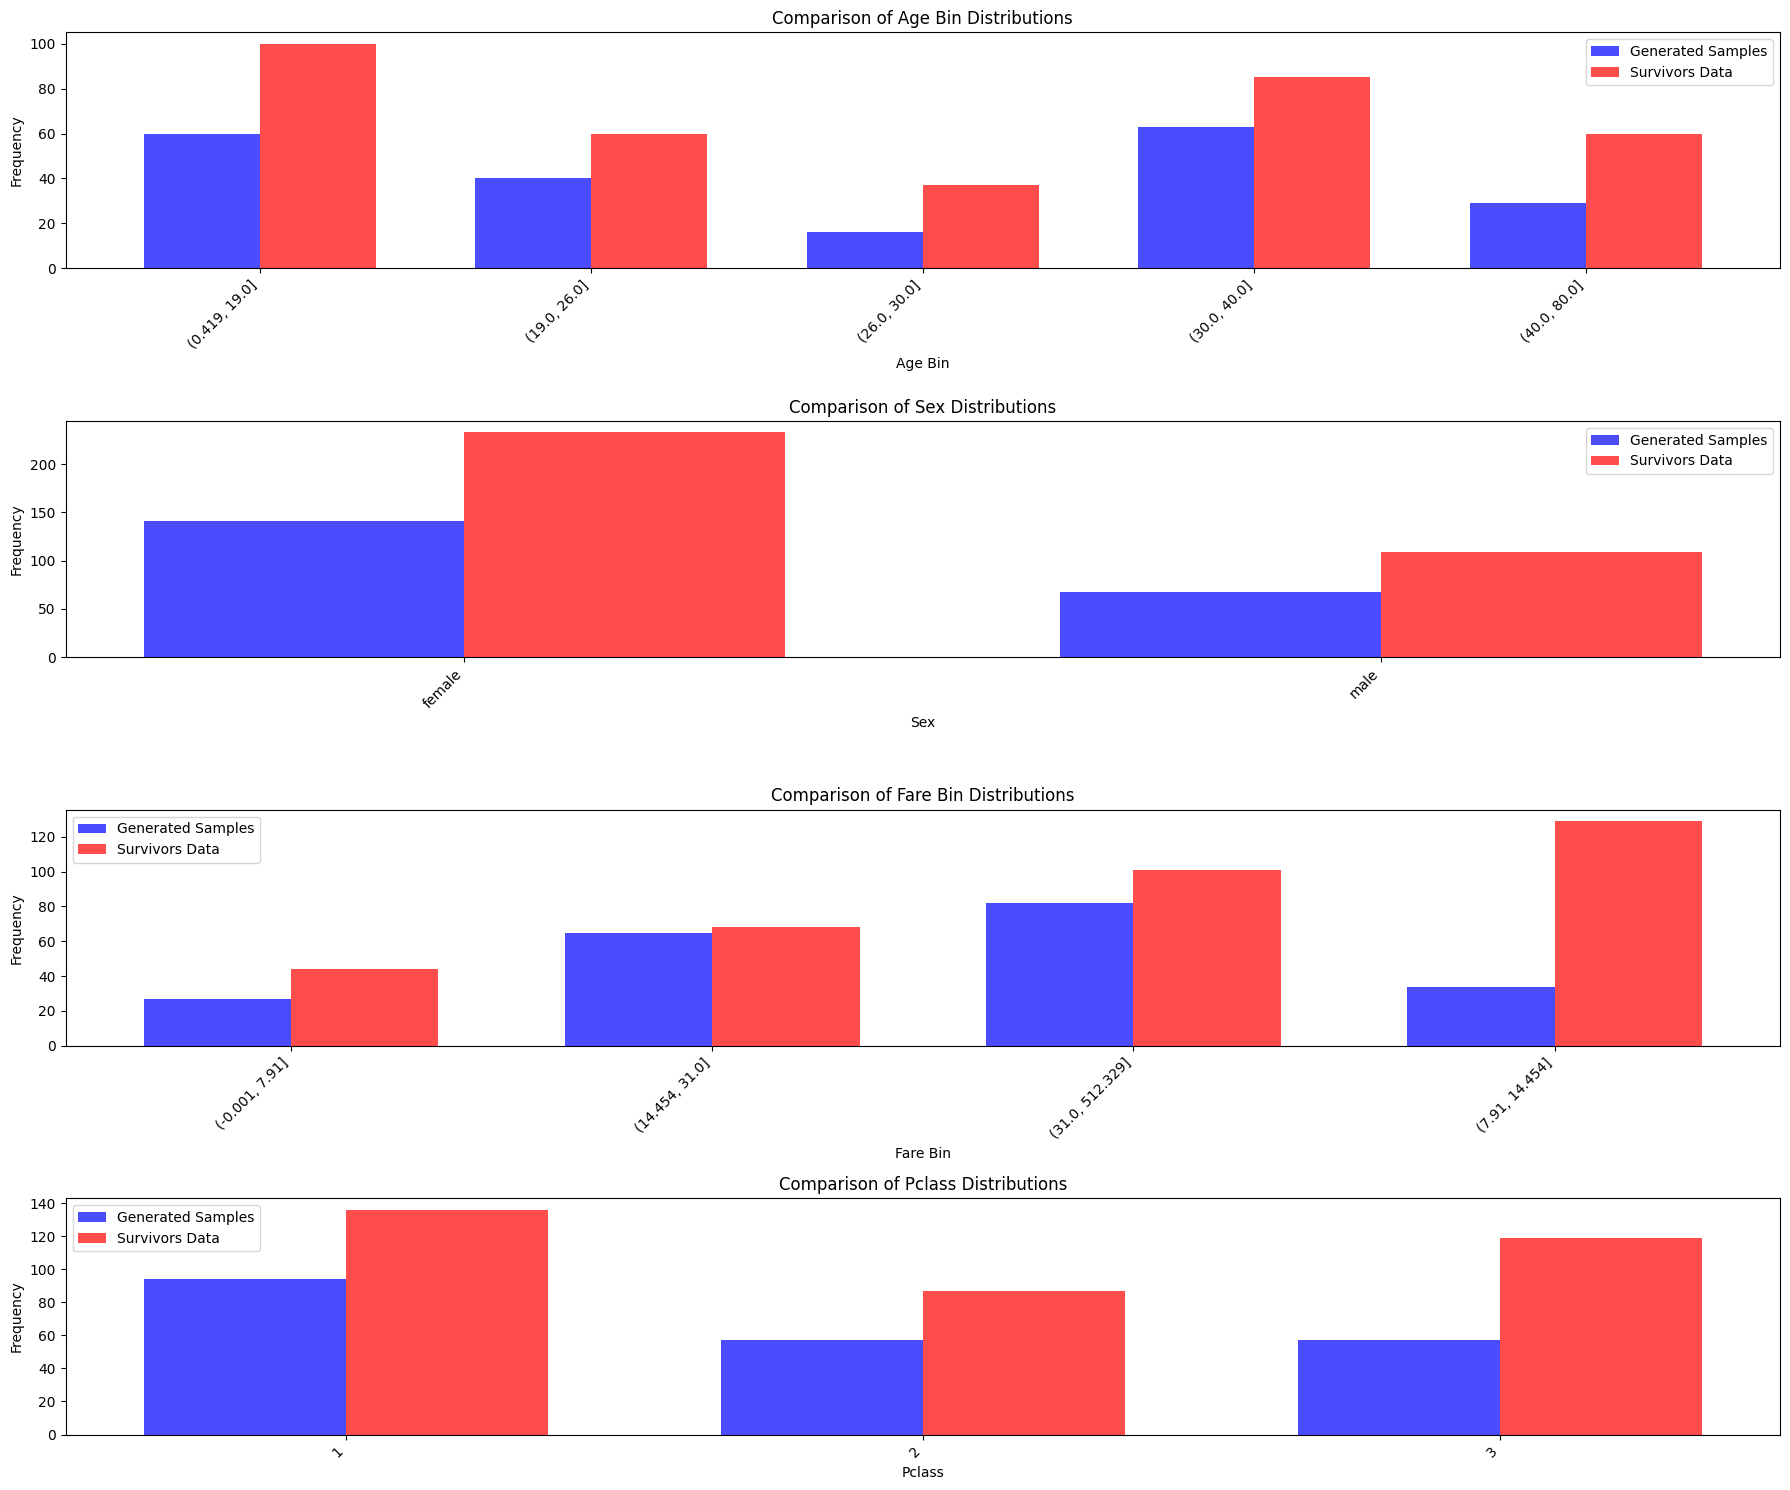

In [ ]:
generated_samples = reversed_df.tail(number_of_generated_samples).copy()
survivors_df = X.copy()
survivors_df['Survived'] = y
survivors_df['Survived_String'] = survivors_df['Survived'].apply(lambda x: str(x))

def interval_to_string(interval):
    if isinstance(interval, pd.Interval):
        return f"({interval.left}, {interval.right}]"
    return str(interval)

for df in [generated_samples, survivors_df]:
    df['AgeBin_String'] = df['AgeBin'].apply(interval_to_string)
    df['FareBin_String'] = df['FareBin'].apply(interval_to_string)

def create_grouped_bar_chart(ax, feature, title):
    x_axis_order = sorted(list(pd.unique(np.concatenate((generated_samples[feature], survivors_df[feature])))))
    bar_width = 0.35
    x_pos = np.arange(len(x_axis_order))

    ax.bar(x_pos - bar_width / 2, generated_samples['Survived'].groupby(generated_samples[feature]).sum(),
           width=bar_width, color='blue', alpha=0.7, label='Generated Samples')
    ax.bar(x_pos + bar_width / 2, survivors_df['Survived'].groupby(survivors_df[feature]).sum(),
           width=bar_width, color='red', alpha=0.7, label='Survivors Data')

    ax.set_xticks(x_pos)
    ax.set_xticklabels(x_axis_order, rotation=45, ha='right')
    ax.set_xlabel(title)
    ax.set_ylabel('Frequency')
    ax.set_title(f'Comparison of {title} Distributions')
    ax.legend()

fig, axes = plt.subplots(4, 1, figsize=(18, 15))

create_grouped_bar_chart(axes[0], 'AgeBin_String', 'Age Bin')
create_grouped_bar_chart(axes[1], 'Sex', 'Sex')
create_grouped_bar_chart(axes[2], 'FareBin_String', 'Fare Bin')
create_grouped_bar_chart(axes[3], 'Pclass', 'Pclass')

plt.tight_layout()
plt.show()

Generated samples's distribution differs from the data. Further analysis of how SMOTE generates newer samples should be made to control if this is expected or not and understand the impact this will have on the predictions.

#### Training the model on data resampled with SMOTE

In [ ]:
resampled_model = GradientBoostingClassifier(random_state=42, learning_rate=0.001, n_estimators=500, max_features=0.6)
resampled_model.fit(X_resampled, y_resampled)

GradientBoostingClassifier(learning_rate=0.001, max_features=0.6,
                           n_estimators=500, random_state=42)

#### SMOTE Resampling model evaluation

In [ ]:
k = 5

skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
X_transformed_smote = dt_preprocessor.transform(X)
scores = cross_val_score(resampled_model, X_transformed_smote, y, cv=skf, scoring='accuracy')
print(f"Mean Cross-Validation Accuracy [{scores.mean()}]")

Mean Cross-Validation Accuracy [0.7991086560793421]


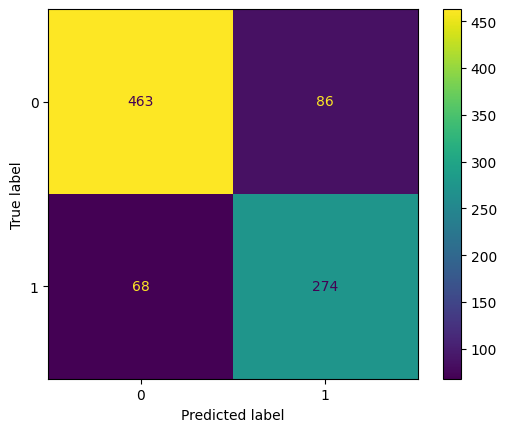

In [ ]:
ConfusionMatrixDisplay(confusion_matrix(y, resampled_model.predict(X_transformed_smote)), display_labels=resampled_model.classes_).plot()

A regression can be observed in the model's overall accuracy which achieves an accuracy score `79.91%` compared to `80%` for the baseline model. Looking at the confusion matrix, allows to understand that the model seems to perform better when predictin the `Survived=1` samples from the minority class, but is less efficient in prediction `Survived=0` than its counterparts models. This could highlight an interesting tradeoff where the model achieves worse results as it loses accuracy on the majority class, this while improving on the minority class. If the competition data is representative of the truth, where `Survived=0` will be more frequent than `Survived=1`, a lower accuracy score should be confirmed. Further will be discussed in the `Discussion` section of the notebook.

#### SMOTE submission

In [ ]:
X_competition_transformed = dt_preprocessor.transform(X_competition)
y_pred_competition=resampled_model.predict(X_competition_transformed)
final_df=pd.DataFrame(data=df_id)
final_df.insert(1, "Survived", y_pred_competition, True)
final_df.to_csv('./submission_resampled.csv', index=False)

The score regression is confirmed as the model achieves an accuracy of `77.51%` compared to `78.47%` for other models.

## Discussion

In this study, a research revolving around optimisation techniques aiming to improve classification accuracy using outlier removal and SMOTE oversampling techniques was conducted. The dataset that was used is coming from the Titanic - Machine Learning from Disaster competition on Kaggle.


The methodology used consisted in doing simple feature engineering that would allow to achieve a relatively good score. Then, training a model on the training data provided in the dataset and evaluate it using cross validation. The score would then be confirmed by making a submission to the competition to understand if the model was still able to perform on completely unseen data and if it was not overfitting. The process would then be repeated with different optimisation techniques, allowing to study them and add more in the future.


First, a baseline model based on GradientBoosting was built, trained and evaluated locally. The model achieved an accuracy of `80.02%` when trained locally, and it was observed that the model was less efficient at predicting samples from the minority class than from the majority class. Then, the same model was reused but trained on a data where an `IsolationForest`, trained in a supervised learning approach, allowed to remove outlier samples from the dataset. The model achieved a slightly better score locally with an accuracy score of `80.97%`. The improvement was not confirmed at submission where the score remained at `78.47%` compared to the baseline. Finally, SMOTE was used to generate new samples from the minority class, it was first observed that the generated samples did not seem too close from the initial ones. The model was then trained on the data with samples generated with SMOTE and a performance degradation was observed on local results. Interestingly, when looking at the confusion matrix, it is visible that the model was now able to perform better on instances from the minority classes, at the expense of the predictions on the majority classes. This regression was later confirmed at submission with an accuracy score of `77.51%`.


Following this iteration, several experiments should be further conducted. First, the outlier points highlighted by the `IsolationForest` should be studied to understand if the model does not delete relevant points that could be a source of information. Fine-tuning the `IsolationForest` model should be subsequently performed to optimise the process of removing outliers.


Several steps could then be attempted in the SMOTE experiment. First, the amount of new samples generated for the minority class should be decreased, as this would allow to understand if the model can still improve it's predictions capabilities on the minority classes while retaining its performance on the majority classes predictions. In addition, the number of nearest neighbours should be adjusted to determine how it impacts the representativeness of the samples.


In addition, more information should be gathered about `SMOTE` and `Outlier removal` to efficiently understand the viability of these options in the context of improving the model's performance for the Kaggle competition. And further feature engineering should be included to search for any significant improvement on the performances.


Finally, while a simple model was initially used for the predicition task, it would be interesting to build a Deep Learning model with data generation to see if it can perform better than classic machine learning models. This should be conducted once thorough feature engineering was made and that the data is well understood. The main reason being that Deep Learning models tends to have poor interpretability and explainability and could lead to better results without a good understanding of the impacts.